In [ ]:
!pip install wfdb
!pip install hrv-analysis
!pip install py-ecg-detectors
!pip install neurokit2

from google.colab import output
output.clear()
print("All packages installed successfully!")

All packages installed successfully!


In [ ]:
import pprint
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import wfdb
import hrvanalysis
import ecgdetectors
import hrv
import neurokit2 as nk

## MIT-BIH Normal Sinus Rhythm Database

https://physionet.org/content/nsrdb/1.0.0/

In [ ]:
# !wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/ -P "/content/drive/MyDrive/Projects/HRV/dataset"

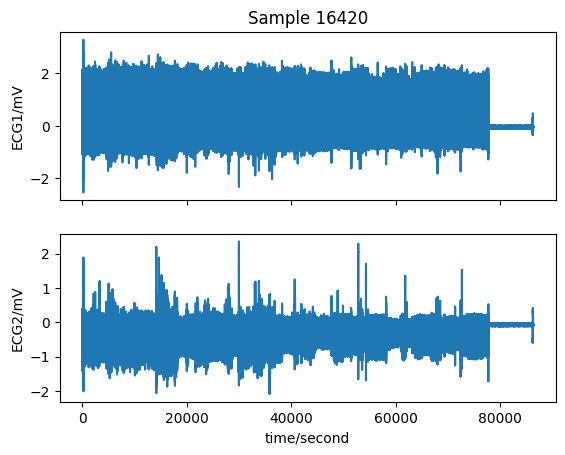

{'adc_gain': [200.0, 200.0],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': datetime.time(9, 55),
 'baseline': [0, 0],
 'block_size': [0, 0],
 'byte_offset': [None, None],
 'checksum': [26371, 32741],
 'comments': ['38 F'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['16420.dat', '16420.dat'],
 'fmt': ['212', '212'],
 'fs': 128,
 'init_value': [-19, -5],
 'n_sig': 2,
 'p_signal': array([[-0.095, -0.025],
       [-0.085, -0.035],
       [-0.085, -0.025],
       ...,
       [-0.07 , -0.075],
       [-0.07 , -0.075],
       [-0.07 , -0.075]]),
 'record_name': '16420',
 'samps_per_frame': [1, 1],
 'sig_len': 11051008,
 'sig_name': ['ECG1', 'ECG2'],
 'skew': [None, None],
 'units': ['mV', 'mV']}


In [ ]:
NSRDB_DIR = "/content/drive/MyDrive/Projects/HRV/dataset/physionet.org/files/nsrdb/1.0.0/"
record = wfdb.rdrecord(os.path.join(NSRDB_DIR, "16420"))
wfdb.plot_wfdb(record=record, title="Sample 16420")
pprint.pprint(record.__dict__)

In [ ]:
record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, "16265"))
record_obj.__dict__

{'record_name': '16265',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11730944,
 'base_time': datetime.time(8, 4),
 'base_date': None,
 'comments': ['32 M'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.165, -0.325],
        [-0.155, -0.325],
        [-0.195, -0.305],
        ...,
        [-0.05 , -0.095],
        [-0.05 , -0.085],
        [-0.05 , -0.085]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16265.dat', '16265.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-33, -65],
 'checksum': [15756, -21174],
 'block_size': [0, 0]}

In [ ]:
def slice_signal(record_obj, start_sec=0, end_sec=10, fs=250, _print=True):
    start = fs*start_sec
    end = fs*end_sec
    signal = record_obj.p_signal[start:end, 0]

    if _print:
        print("start        :", start)
        print("end          :", end)
        print("end - start  :", end - start)
        print("len(signal)  :", len(signal))
        print("seconds      :", end_sec - start_sec)

    detectors = ecgdetectors.Detectors(fs)
    r_peaks = detectors.two_average_detector(signal)
    if _print:
        print("len(r_peaks) :", len(r_peaks))
    return signal, r_peaks

def plot_signal(signal: np.array, r_peaks: list=None, figsize=(6, 4), title=None):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("mV")
    if title:
        plt.title(str(title))

    # ref: https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
    if r_peaks:
        for xc in r_peaks:
            plt.axvline(x=xc, color='red', linestyle='--')

    plt.show()

In [ ]:
def segment(record_obj, start_sec=0, end_sec=20, size_sec=5, fs=250, _plot_signal=True, _print=True):
    short_term_signals = []
    short_term_r_peaks = []

    if end_sec == 'full':
        end_sec = len(record_obj.p_signal[:, 0]) // FS

    for _start_sec in range(start_sec, end_sec, size_sec):
        # get the signal slice and the corresponding r-peaks
        signal, r_peaks = slice_signal(
            record_obj,
            start_sec=_start_sec,
            end_sec=_start_sec+size_sec,
            fs=fs,
            _print=_print
        )
        # adjust the time points according to the frequency and the slice part
        r_peaks = list(np.array(r_peaks) + _start_sec*fs)
        # append the segmented signals and the corresponding r peaks
        short_term_r_peaks.append(r_peaks)
        short_term_signals.append(signal)

        if _plot_signal:
            plot_signal(signal, r_peaks)
        if _print:
            print(r_peaks)

    if _print:
        print("len(short_term_signals):", len(short_term_signals))
        print("len(short_term_r_peaks):", len(short_term_r_peaks))

    return short_term_signals, short_term_r_peaks

In [ ]:
from google.colab import output

DATABASE = "nsrdb"
SAVE_DIR = "./dataset"
os.makedirs(os.path.join(SAVE_DIR, DATABASE), exist_ok=True)

start_time = datetime.datetime.now()

nsrdb = {}

MENIT = 1
START_SEC = 0
END_SEC = "full"
SIZE_SEC = int(60 * MENIT)
FS = 128
_PLOT_SIGNAL = False
_PRINT = False
print("FS:", FS)
errs = []
for record in wfdb.get_record_list(DATABASE):
    try:
        print("Record:", record)
        record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))
        print("  signal length          :", record_obj.sig_len)
        print("  recording time (hours) :", record_obj.sig_len / (3600*FS))
        print("  comments               :", record_obj.comments)

        short_term_signals, short_term_r_peaks = segment(
            record_obj,
            start_sec=START_SEC,
            end_sec=END_SEC,
            size_sec=SIZE_SEC,
            fs=FS,
            _plot_signal=_PLOT_SIGNAL,
            _print=_PRINT
        )
        # for each corresponding signal and r-peaks
        for idx, (signal, r_peaks) in enumerate(zip(short_term_signals, short_term_r_peaks)):
            print("Record                   :", record)
            print("seconds                  : {} to {}".format(SIZE_SEC * idx, SIZE_SEC * (1+idx)))
            try:
                # retrieve rr_interval from distance between 2 r_peak points
                rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
                # convert the unit from freq_sample to milisecond
                rri = list(np.array(rri) * 1000 / FS)
                print("  len(r_peaks)           :", len(r_peaks))
                print("  len(rri)               :", len(rri))
                print("  recording time (secs)  :", record_obj.sig_len / FS)
                print("  r_peak / seconds       :", len(r_peaks) / (record_obj.sig_len / FS))

                nni = hrvanalysis.get_nn_intervals(rri)
                print("  len(nni)               :", len(nni))
                time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
                print("  time_domain computed!")
                freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
                print("  freq_domain computed!")
                geom = hrvanalysis.extract_features.get_geometrical_features(nni)
                print("  geometrical features computed!")
                poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
                print("  poincare features computed!")
                csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
                print("  csi cvi computed!")
                # Function computing the sample entropy of the given data.
                # Must use this function on short term recordings, from 1 minute window.
                sampen = hrvanalysis.extract_features.get_sampen(nni)
                print("  sampen computed!")

                # save signal into parquet
                sig_array = np.array(signal, dtype=np.int32)
                filename = "{0}-{1}-{2}-{3}".format(DATABASE, record, SIZE_SEC*idx, SIZE_SEC*(1+idx))
                filepath = os.path.join(SAVE_DIR, DATABASE, str(filename)+".parquet")
                pd.DataFrame({"data": sig_array}).to_parquet(filepath)
                print("{0}.parquet saved!".format(filename))
                # signal saved!

                id = filename
                nsrdb[id] = {
                    "id": id,
                    "start_secs": SIZE_SEC * idx,
                    "end_secs": SIZE_SEC * (1+idx),
                    "db_source": DATABASE,
                    "age": record_obj.comments[0].split()[0],
                    "gender": record_obj.comments[0].split()[1],
                    "fs": FS,
                    "signal_length": record_obj.sig_len,
                    "recording_time_hours": record_obj.sig_len / (3600 * FS),
                    "recording_time_seconds": record_obj.sig_len // FS,
                    "rri_length": len(rri),
                    "nni_length": len(nni),
                    **time_domain,
                    **freq_domain,
                    **geom,
                    **poincare,
                    **csi_cvi,
                    **sampen,
                    "cardiac_info": "Sinus",
                    "risk": 0,
                }
                print("RECORD {} SAVED!".format(record))
            except Exception as e:
                # import logging
                # import traceback
                # logging.error(traceback.format_exc())
                # Ref: https://stackoverflow.com/a/4990739
                import sys
                print("  UNEXPECTED ERROR: {0}\n  {1}".format(sys.exc_info()[0], record))
                errs.append(filename)
            output.clear()
    except:
        print("\n ERROR (%s)\n" %record)

print("Running time :", datetime.datetime.now() - start_time)
print("Errors       :", errs)

In [ ]:
# pprint.pprint(nsrdb)

In [ ]:
df_nsrdb = pd.DataFrame(nsrdb).T
df_nsrdb

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
nsrdb-16265-0-60,nsrdb-16265-0-60,0,60,nsrdb,32,M,128,11730944,25.457778,91648,...,None,52.660413,37.734179,0.716557,0.716557,4.502339,108.154739,1.084626,Sinus,0
nsrdb-16265-60-120,nsrdb-16265-60-120,60,120,nsrdb,32,M,128,11730944,25.457778,91648,...,None,54.279557,48.020582,0.88469,0.88469,4.620184,169.933321,1.013619,Sinus,0
nsrdb-16265-120-180,nsrdb-16265-120-180,120,180,nsrdb,32,M,128,11730944,25.457778,91648,...,None,49.172784,43.254923,0.879652,0.879652,4.53188,152.197068,1.554088,Sinus,0
nsrdb-16265-180-240,nsrdb-16265-180-240,180,240,nsrdb,32,M,128,11730944,25.457778,91648,...,None,55.82873,66.691676,1.194576,1.194576,4.775049,318.673173,1.239691,Sinus,0
nsrdb-16265-240-300,nsrdb-16265-240-300,240,300,nsrdb,32,M,128,11730944,25.457778,91648,...,None,45.319365,47.23897,1.042357,1.042357,4.534704,196.959532,1.316336,Sinus,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nsrdb-19830-83340-83400,nsrdb-19830-83340-83400,83340,83400,nsrdb,50,F,128,10701824,23.224444,83608,...,None,128.545152,260.422183,2.02592,2.02592,5.728854,2110.377937,1.406914,Sinus,0
nsrdb-19830-83400-83460,nsrdb-19830-83400-83460,83400,83460,nsrdb,50,F,128,10701824,23.224444,83608,...,None,194.716228,377.079331,1.936558,1.936558,6.069955,2920.944453,1.573506,Sinus,0
nsrdb-19830-83460-83520,nsrdb-19830-83460-83520,83460,83520,nsrdb,50,F,128,10701824,23.224444,83608,...,None,86.652709,213.627178,2.465326,2.465326,5.471559,2106.642555,1.329136,Sinus,0
nsrdb-19830-83520-83580,nsrdb-19830-83520-83580,83520,83580,nsrdb,50,F,128,10701824,23.224444,83608,...,None,119.896375,301.168426,2.511906,2.511906,5.761735,3026.027139,1.252763,Sinus,0


In [ ]:
df_nsrdb.to_csv("df_nsrdb_two_average.csv", index=False)
df_nsrdb.to_excel("df_nsrdb_two_average.xlsx", index=False)

In [ ]:
pd.read_csv("df_nsrdb_two_average.csv")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265-0-60,0,60,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,52.660413,37.734179,0.716557,0.716557,4.502339,108.154739,1.084626,Sinus,0
1,nsrdb-16265-60-120,60,120,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,54.279557,48.020582,0.884690,0.884690,4.620184,169.933321,1.013619,Sinus,0
2,nsrdb-16265-120-180,120,180,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,49.172784,43.254923,0.879652,0.879652,4.531880,152.197068,1.554088,Sinus,0
3,nsrdb-16265-180-240,180,240,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,55.828730,66.691676,1.194576,1.194576,4.775049,318.673173,1.239691,Sinus,0
4,nsrdb-16265-240-300,240,300,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,45.319365,47.238970,1.042357,1.042357,4.534704,196.959532,1.316336,Sinus,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26248,nsrdb-19830-83340-83400,83340,83400,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,128.545152,260.422183,2.025920,2.025920,5.728854,2110.377937,1.406914,Sinus,0
26249,nsrdb-19830-83400-83460,83400,83460,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,194.716228,377.079331,1.936558,1.936558,6.069955,2920.944453,1.573506,Sinus,0
26250,nsrdb-19830-83460-83520,83460,83520,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,86.652709,213.627178,2.465326,2.465326,5.471559,2106.642555,1.329136,Sinus,0
26251,nsrdb-19830-83520-83580,83520,83580,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,119.896375,301.168426,2.511906,2.511906,5.761735,3026.027139,1.252763,Sinus,0


In [ ]:
pd.read_excel("df_nsrdb_two_average.xlsx")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265-0-120,0,120,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,53.886179,45.253967,0.839807,0.839807,4.591254,152.018313,1.159468,Sinus,0
1,nsrdb-16265-120-240,120,240,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,52.855934,59.371841,1.123277,1.123277,4.700794,266.764028,1.396657,Sinus,0
2,nsrdb-16265-240-360,240,360,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,35.882878,72.581287,2.022728,2.022728,4.619832,587.248680,0.592011,Sinus,0
3,nsrdb-16265-360-480,360,480,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,21.669505,44.770424,2.066057,2.066057,4.190960,369.992936,1.697269,Sinus,0
4,nsrdb-16265-480-600,480,600,nsrdb,32,M,128,11730944,25.457778,91648,...,NaN,24.334961,90.747031,3.729081,3.729081,4.548183,1353.611981,0.300901,Sinus,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13125,nsrdb-19830-83040-83160,83040,83160,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,130.113644,286.553471,2.202332,2.202332,5.775648,2524.343778,1.550597,Sinus,0
13126,nsrdb-19830-83160-83280,83160,83280,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,94.402302,289.439174,3.066018,3.066018,5.640660,3549.703056,1.260971,Sinus,0
13127,nsrdb-19830-83280-83400,83280,83400,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,123.802964,270.515664,2.185050,2.185050,5.729043,2364.360976,1.382380,Sinus,0
13128,nsrdb-19830-83400-83520,83400,83520,nsrdb,50,F,128,10701824,23.224444,83608,...,NaN,147.243472,313.336899,2.128019,2.128019,5.868168,2667.147451,1.260368,Sinus,0


## Checking annotation

In [ ]:
FS = 128

In [ ]:
print(wfdb.get_record_list("nsrdb"))

['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']


In [ ]:
record = "16265"
rec_ann = wfdb.rdann(os.path.join(NSRDB_DIR, record), extension='atr')
rec_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))

In [ ]:
anns = rec_ann.sample
anns[:100]

array([   1,   52,  129,  207,  284,  364,  442,  522,  598,  675,  754,
        833,  916,  996, 1075, 1155, 1238, 1321, 1403, 1483, 1564, 1644,
       1723, 1802, 1882, 1961, 2038, 2117, 2197, 2278, 2357, 2438, 2522,
       2606, 2691, 2774, 2856, 2941, 3029, 3113, 3195, 3277, 3360, 3441,
       3522, 3601, 3681, 3761, 3840, 3920, 4000, 4079, 4159, 4240, 4323,
       4406, 4487, 4569, 4651, 4733, 4813, 4895, 4978, 5062, 5144, 5225,
       5308, 5389, 5469, 5550, 5631, 5712, 5796, 5881, 5967, 6052, 6133,
       6214, 6296, 6375, 6455, 6533, 6612, 6691, 6769, 6846, 6924, 7004,
       7082, 7159, 7238, 7319, 7397, 7473, 7549, 7627, 7705, 7783, 7861,
       7941])

In [ ]:
def plot_signal(signal: np.array, r_peaks: list=None, figsize=(6, 4), title=None):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("mV")
    if title:
        plt.title(str(title))

    # ref: https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
    if r_peaks:
        for xc in r_peaks:
            if xc <= len(signal):
                plt.axvline(x=xc, color='red', linestyle='--')

    plt.xlabel("time point")
    plt.show()

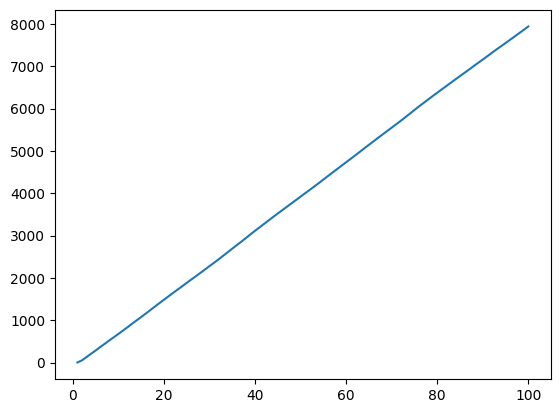

In [ ]:
ann_to_plot = anns[:100]
xs = [i+1 for i in range(len(ann_to_plot))]
plt.plot(xs, ann_to_plot)
plt.show()

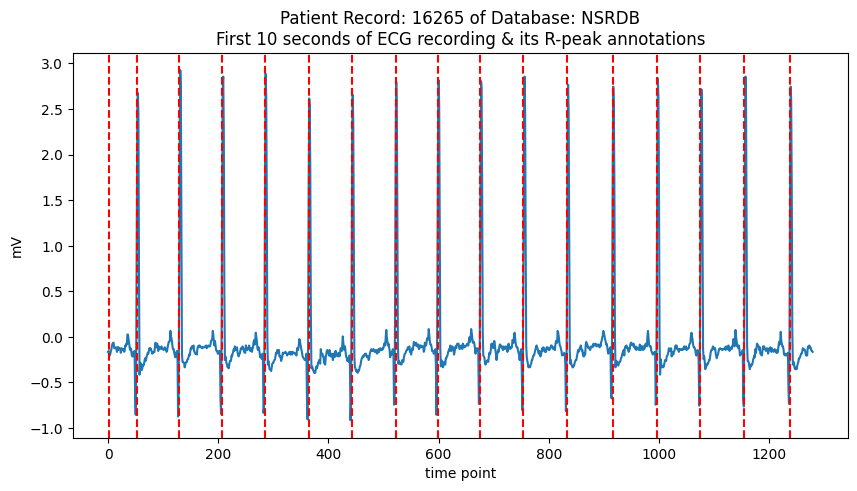

In [ ]:
SECONDS = 10
title = "Patient Record: {0} of Database: NSRDB\nFirst {1} seconds of ECG recording & its R-peak annotations".format(record, SECONDS)
plot_signal(
    rec_obj.p_signal[:FS*SECONDS, 0],
    r_peaks=list(anns[:500]),
    title=title,
    figsize=(10, 5)
)

In [ ]:
record = "19140"
rec_ann = wfdb.rdann(os.path.join(NSRDB_DIR, record), extension='atr')
rec_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))

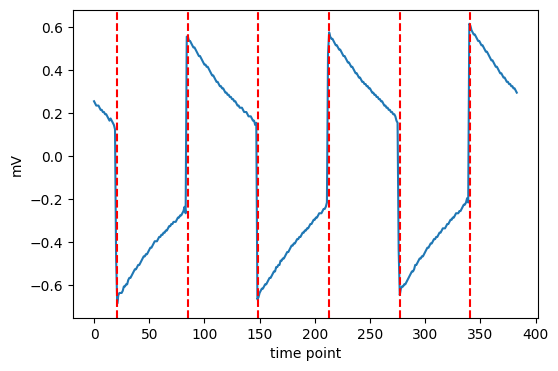

In [ ]:
anns = rec_ann.sample[:10]
plot_signal(rec_obj.p_signal[:FS*3, 0], r_peaks=list(anns[:6]))

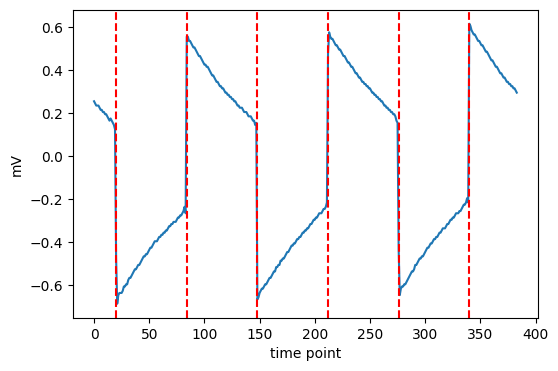

In [ ]:
anns = rec_ann.sample[:10] - 1
plot_signal(rec_obj.p_signal[:FS*3, 0], r_peaks=list(anns[:6]))

In [ ]:
## Plot RR interval


## Uses Defined Annotation

In [ ]:
from google.colab import output

DATABASE = "nsrdb"

start_time = datetime.datetime.now()

FS = 128

MENIT = 5
SIZE_SEC = int(60 * MENIT)
WINDOW_SIZE = SIZE_SEC * FS

END_SEC = int(60 * 120) * FS
# END_SEC = max(r_peaks)

# OVERLAP means percentage of overlap, values between [0, 1)
OVERLAP = 0.5

nsrdb = {}
errs = []
for record in wfdb.get_record_list(DATABASE):
    ann = wfdb.rdann(os.path.join(NSRDB_DIR, record), extension='atr')
    record_hea = wfdb.rdheader(os.path.join(NSRDB_DIR, record))
    record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))

    r_peaks = np.array(ann.sample, dtype=np.float32)
    annotation = np.array(ann.symbol)

    start_sec = 0
    while start_sec < END_SEC:
        output.clear()
        end_sec = start_sec + WINDOW_SIZE

        print("New Record           :", record)
        print("  Start Sec          : %d" % int(start_sec//FS))
        print("  End Sec            : %d" % int(end_sec//FS))

        cond = (start_sec <= r_peaks) & (r_peaks < end_sec)
        _r_peak = r_peaks[cond]
        _annotation = annotation[cond]

        # counting ectopic beats
        abnormal_beat_num = 0
        for _sym, _count in np.transpose(np.unique(_annotation, return_counts=True)):
            if _sym != 'N':
                abnormal_beat_num += int(_count)
            if _sym == 'N':
                normal_beat_num = int(_count)
        normal_beats_ratio = normal_beat_num / (normal_beat_num + abnormal_beat_num)

        # check & replace ectopic beat with np.nan
        for idx, ann in enumerate(_annotation):
            if str(ann).upper() != 'N':
                _r_peak[idx] = np.nan
        # interpolate
        _r_peak = hrvanalysis.preprocessing.interpolate_nan_values(_r_peak)

        # retrieve rr_interval from distance between 2 r_peak points
        rri = [_r_peak[i+1] - _r_peak[i] for i in range(len(_r_peak) - 1)]
        # convert the unit from freq_sample to milisecond
        rri = list(np.array(rri) * 1000 / FS)
        # print("  len(_r_peak)           :", len(_r_peak))
        # print("  len(rri)               :", len(rri))

        id = "{0}-{1}-{2}-{3}".format(DATABASE, record, start_sec//FS, end_sec//FS)
        try:
            rri = hrvanalysis.preprocessing.remove_outliers(
                rri,
                low_rri = 300,
                high_rri = 2000,
            )
            nni = hrvanalysis.preprocessing.interpolate_nan_values(rri)

            # remove nan values if exists
            nni = [val for val in nni if np.isfinite(val)]
            # print("  len(nni)               :", len(nni))
            time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
            # print("  time_domain computed!")
            freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
            # print("  freq_domain computed!")
            geom = hrvanalysis.extract_features.get_geometrical_features(nni)
            # print("  geometrical features computed!")
            poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
            # print("  poincare features computed!")
            csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
            # print("  csi cvi computed!")
            # Function computing the sample entropy of the given data.
            # Must use this function on short term recordings, from 1 minute window.
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            # print("  sampen computed!")

            nsrdb[id] = {
                "id": id,
                "start_secs": start_sec // FS,
                "end_secs": end_sec // FS,
                "db_source": DATABASE,
                "age": record_obj.comments[0].split()[0],
                "gender": record_obj.comments[0].split()[1],
                "fs": FS,
                "signal_length": record_obj.sig_len,
                "recording_time_hours": record_obj.sig_len / (3600 * FS),
                "recording_time_seconds": record_obj.sig_len // FS,
                "normal_beats": normal_beat_num,
                "abnormal_beats": abnormal_beat_num,
                "normal_beats_ratio": normal_beats_ratio,
                "rri_length": len(rri),
                "nni_length": len(nni),
                **time_domain,
                **freq_domain,
                **geom,
                **poincare,
                **csi_cvi,
                **sampen,
                "cardiac_info": "Sinus",
                "risk": 0,
            }
            print("  RECORD {} SAVED!\n".format(id))
        except:
            print("  \nERROR at {}\n".format(id))
            errs.append(id)
        finally:
            start_sec = start_sec + int(WINDOW_SIZE * (1 - OVERLAP))

print("\n"+"="*50)
print(datetime.datetime.now() - start_time)
print("error nums   :", len(errs))

New Record           : 16272
  Start Sec          : 7050
  End Sec            : 7350
0 outlier(s) have been deleted.
  
ERROR at nsrdb-16272-7050-7350



KeyboardInterrupt: ignored

In [ ]:
df_nsrdb = pd.DataFrame(nsrdb).T
df_nsrdb.sample(2)

In [ ]:
df_nsrdb.to_csv("df_nsrdb.csv", index=False)
df_nsrdb.to_excel("df_nsrdb.xlsx", index=False)

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
pd.read_csv("df_nsrdb.csv")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265-0-300,0,300,nsrdb,32,M,128,11730944,25.457778,91648,482,2,0.995868,483,482,622.358013,31.972744,17.158836,7,1.455301,99,20.582121,17.159028,617.1875,265.625000,0.027571,0.051374,96.652930,112.941176,75.294118,4.807567,561.246217,111.197262,5.047303,83.463701,16.536299,906.095372,233.651893,8.607143,NaN,12.145761,43.554486,3.585982,3.585982,3.927578,624.742468,1.913097,Sinus,0
1,nsrdb-16265-150-450,150,450,nsrdb,32,M,128,11730944,25.457778,91648,512,4,0.992248,515,515,585.512743,51.238525,17.053998,8,1.556420,103,20.038911,17.054242,585.9375,304.687500,0.029127,0.087511,103.239305,121.904762,75.294118,8.804447,470.587740,103.863810,4.530815,81.919483,18.080517,1080.760124,506.308574,15.606061,NaN,12.070745,71.449773,5.919251,5.919251,4.139855,1691.716592,0.819348,Sinus,0
2,nsrdb-16265-300-600,300,600,nsrdb,32,M,128,11730944,25.457778,91648,551,22,0.961606,572,572,530.348558,55.258950,22.434748,7,1.225919,97,16.987741,22.434952,531.2500,531.738281,0.042302,0.104194,114.287907,145.076741,63.471074,11.335505,178.467520,48.258748,3.698138,78.714973,21.285027,736.016838,509.290569,11.000000,NaN,15.877672,76.517988,4.819220,4.819220,4.288670,1475.027968,0.648784,Sinus,0
3,nsrdb-16265-450-750,450,750,nsrdb,32,M,128,11730944,25.457778,91648,493,21,0.959144,513,513,588.374147,117.691394,51.592082,46,8.984375,176,34.375000,51.592590,554.6875,644.531250,0.087687,0.200028,105.964816,185.060241,61.935484,20.490982,1328.878424,703.693425,1.888434,65.379161,34.620839,3686.643387,1654.071538,14.657143,NaN,36.516790,162.385506,4.446872,4.446872,4.977160,2888.430546,0.294255,Sinus,0
4,nsrdb-16265-600-900,600,900,nsrdb,32,M,128,11730944,25.457778,91648,425,6,0.986079,430,430,695.748547,88.453643,73.782553,61,14.219114,208,48.484848,73.782562,695.3125,664.062500,0.106048,0.127134,88.262908,196.923077,61.935484,17.073251,1588.777347,1329.876343,1.194681,54.435281,45.564719,4081.740238,1163.086548,13.030303,NaN,52.233057,113.665306,2.176118,2.176118,4.977693,989.396563,0.931895,Sinus,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,nsrdb-19830-6450-6750,6450,6750,nsrdb,50,F,128,10701824,23.224444,83608,557,2,0.996422,558,558,538.152442,15.587886,9.268693,0,0.000000,16,2.872531,9.268735,539.0625,109.375000,0.017223,0.028966,111.584595,120.000000,98.461538,3.182618,60.778027,12.525744,4.852249,82.912551,17.087449,122.730499,49.426728,4.894737,NaN,6.559847,21.045969,3.208302,3.208302,3.344183,270.087299,1.280164,Sinus,0
860,nsrdb-19830-6600-6900,6600,6900,nsrdb,50,F,128,10701824,23.224444,83608,550,22,0.961538,571,571,534.888593,26.252520,12.311743,1,0.175439,40,7.017544,12.311743,539.0625,211.914062,0.023017,0.049080,112.494787,150.958231,98.461538,6.632878,205.241068,28.756930,7.137099,87.710608,12.289392,382.719438,148.721439,6.010526,NaN,8.713363,36.089707,4.141880,4.141880,3.701689,597.916963,1.239884,Sinus,0
861,nsrdb-19830-6750-7050,6750,7050,nsrdb,50,F,128,10701824,23.224444,83608,540,41,0.929432,580,580,533.182078,29.009571,12.940612,2,0.345423,49,8.462867,12.940619,539.0625,188.476562,0.024271,0.054408,112.928673,150.958231,102.400000,7.354128,411.058119,39.881170,10.307073,91.155978,8.844022,748.621911,297.682623,5.420561,NaN,9.158306,39.990448,4.366577,4.366577,3.767891,698.485436,1.222378,Sinus,0
862,nsrdb-19830-6900-7200,6900,7200,nsrdb,50,F,128,10701824,23.224444,83608,541,21,0.962633,561,561,543.038380,22.420963,11.209914,1,0.178571,42,7.500000,11.2101

In [ ]:
pd.read_excel("df_nsrdb.xlsx")

## DEMO

In [ ]:
from google.colab import output

DATABASE = "nsrdb"

start_time = datetime.datetime.now()

FS = 128

MENIT = 5
SIZE_SEC = int(60 * MENIT)
WINDOW_SIZE = SIZE_SEC * FS

END_SEC = int(60 * 120) * FS
# END_SEC = max(r_peaks)

# OVERLAP means percentage of overlap, values between [0, 1)
OVERLAP = 0.5

nsrdb = {}
errs = []
for record in wfdb.get_record_list(DATABASE)[:1]:
    ann = wfdb.rdann(os.path.join(NSRDB_DIR, record), extension='atr')
    record_hea = wfdb.rdheader(os.path.join(NSRDB_DIR, record))
    record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))

    r_peaks = np.array(ann.sample, dtype=np.float32)
    annotation = np.array(ann.symbol)

    start_sec = 0
    while start_sec < END_SEC:
        output.clear()
        end_sec = start_sec + WINDOW_SIZE

        print("New Record           :", record)
        print("  Start Sec          : %d" % int(start_sec//FS))
        print("  End Sec            : %d" % int(end_sec//FS))

        cond = (start_sec <= r_peaks) & (r_peaks < end_sec)
        _r_peak = r_peaks[cond]
        _annotation = annotation[cond]

        __r_peak_loc =  _r_peak.copy()
        __annotation = _annotation.copy()

        # counting ectopic beats
        abnormal_beat_num = 0
        for _sym, _count in np.transpose(np.unique(_annotation, return_counts=True)):
            if _sym != 'N':
                abnormal_beat_num += int(_count)
            if _sym == 'N':
                normal_beat_num = int(_count)
        normal_beats_ratio = normal_beat_num / (normal_beat_num + abnormal_beat_num)

        # check & replace ectopic beat with np.nan
        for idx, ann in enumerate(_annotation):
            if str(ann).upper() != 'N':
                _r_peak[idx] = np.nan
        # interpolate
        _r_peak = hrvanalysis.preprocessing.interpolate_nan_values(_r_peak)

        __r_peak_post_ectopic = _r_peak.copy()

        # retrieve rr_interval from distance between 2 r_peak points
        rri = [_r_peak[i+1] - _r_peak[i] for i in range(len(_r_peak) - 1)]
        __rri_pre_normalization = np.array(rri).copy()
        # convert the unit from freq_sample to milisecond
        rri = list(np.array(rri) * 1000 / FS)
        __rri_post_normalization = np.array(rri).copy()
        # print("  len(_r_peak)           :", len(_r_peak))
        # print("  len(rri)               :", len(rri))

        id = "{0}-{1}-{2}-{3}".format(DATABASE, record, start_sec//FS, end_sec//FS)
        try:
            rri = hrvanalysis.preprocessing.remove_outliers(
                rri,
                low_rri = 300,
                high_rri = 2000,
            )
            nni = hrvanalysis.preprocessing.interpolate_nan_values(rri)
            __rri_post_outliers = nni.copy()

            # remove nan values if exists
            nni = [val for val in nni if np.isfinite(val)]
            # print("  len(nni)               :", len(nni))
            time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
            # print("  time_domain computed!")
            freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
            # print("  freq_domain computed!")
            geom = hrvanalysis.extract_features.get_geometrical_features(nni)
            # print("  geometrical features computed!")
            poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
            # print("  poincare features computed!")
            csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
            # print("  csi cvi computed!")
            # Function computing the sample entropy of the given data.
            # Must use this function on short term recordings, from 1 minute window.
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            # print("  sampen computed!")

            nsrdb[id] = {
                "id": id,
                "start_secs": start_sec // FS,
                "end_secs": end_sec // FS,
                "db_source": DATABASE,
                "age": record_obj.comments[0].split()[0],
                "gender": record_obj.comments[0].split()[1],
                "fs": FS,
                "signal_length": record_obj.sig_len,
                "recording_time_hours": record_obj.sig_len / (3600 * FS),
                "recording_time_seconds": record_obj.sig_len // FS,
                "normal_beats": normal_beat_num,
                "abnormal_beats": abnormal_beat_num,
                "normal_beats_ratio": normal_beats_ratio,
                "rri_length": len(rri),
                "nni_length": len(nni),
                **time_domain,
                **freq_domain,
                **geom,
                **poincare,
                **csi_cvi,
                **sampen,
                "cardiac_info": "Sinus",
                "risk": 0,

                # for examples
                "__r_peak_loc": __r_peak_loc,
                "__annotation": __annotation,
                "__r_peak_post_ectopic": __r_peak_post_ectopic,
                "__rri_pre_normalization": __rri_pre_normalization,
                "__rri_post_normalization": __rri_post_normalization,
                "__rri_post_outliers": __rri_post_outliers,
            }
            print("  RECORD {} SAVED!\n".format(id))
        except:
            print("  \nERROR at {}\n".format(id))
            errs.append(id)
        finally:
            start_sec = start_sec + int(WINDOW_SIZE * (1 - OVERLAP))

print("\n"+"="*50)
print(datetime.datetime.now() - start_time)
print("error nums   :", len(errs))

New Record           : 16265
  Start Sec          : 7050
  End Sec            : 7350
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [250.0, 250.0, 273.4375, 273.4375]
  RECORD nsrdb-16265-7050-7350 SAVED!


0:00:14.950041
error nums   : 0


In [ ]:
for sam, vals in nsrdb.items():
    print(sam, "--", np.unique(vals["__annotation"]))

nsrdb-16265-0-300 -- ['N' '|' '~']
nsrdb-16265-150-450 -- ['N' '~']
nsrdb-16265-300-600 -- ['N' '|' '~']
nsrdb-16265-450-750 -- ['N' '|' '~']
nsrdb-16265-600-900 -- ['N' '~']
nsrdb-16265-750-1050 -- ['N' '~']
nsrdb-16265-900-1200 -- ['N']
nsrdb-16265-1050-1350 -- ['N']
nsrdb-16265-1200-1500 -- ['N']
nsrdb-16265-1350-1650 -- ['N']
nsrdb-16265-1500-1800 -- ['N']
nsrdb-16265-1650-1950 -- ['F' 'N']
nsrdb-16265-1800-2100 -- ['F' 'N']
nsrdb-16265-1950-2250 -- ['N']
nsrdb-16265-2100-2400 -- ['N']
nsrdb-16265-2250-2550 -- ['N' 'V']
nsrdb-16265-2400-2700 -- ['N' 'V']
nsrdb-16265-2550-2850 -- ['N']
nsrdb-16265-2700-3000 -- ['N' '~']
nsrdb-16265-2850-3150 -- ['N' 'V' '~']
nsrdb-16265-3000-3300 -- ['N' 'V']
nsrdb-16265-3150-3450 -- ['N' 'V' '~']
nsrdb-16265-3300-3600 -- ['N' '~']
nsrdb-16265-3450-3750 -- ['N' '~']
nsrdb-16265-3600-3900 -- ['N' '~']
nsrdb-16265-3750-4050 -- ['N' '|' '~']
nsrdb-16265-3900-4200 -- ['N' '|' '~']
nsrdb-16265-4050-4350 -- ['N' '|' '~']
nsrdb-16265-4200-4500 -- ['N']
nsr

In [ ]:
sample_record = "nsrdb-16265-300-600"
# sample_record = "nsrdb-16265-2400-2700"
nsrdb[sample_record].keys()
samp__r_peak_loc = nsrdb[sample_record]["__r_peak_loc"]
samp__annotation = nsrdb[sample_record]["__annotation"]
samp__r_peak_post_ectopic = nsrdb[sample_record]["__r_peak_post_ectopic"]
samp__rri_pre_normalization = nsrdb[sample_record]["__rri_pre_normalization"]
samp__rri_post_normalization = nsrdb[sample_record]["__rri_post_normalization"]
samp__rri_post_outliers = nsrdb[sample_record]["__rri_post_outliers"]

In [ ]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

In [ ]:
hrv_index = []
hrv_value = []
for key, value in nsrdb[sample_record].items():
    if key in time_domain_indices + freq_domain_indices + poincare_plot_indices + csi_csv_indices:
        hrv_index.append(key)
        hrv_value.append(value)

df_hrv = pd.DataFrame({
    "Value": hrv_value
}, index=hrv_index).T
df_hrv["sd1_sd2_ratio"] = df_hrv["sd1"] / df_hrv["sd2"]
df_hrv.T

,Value
mean_nni,530.348558
sdnn,55.258950
sdsd,22.434748
nni_50,7.000000
pnni_50,1.225919
nni_20,97.000000
pnni_20,16.987741
rmssd,22.434952
median_nni,531.250000
range_nni,531.738281


<ipython-input-13-22e56e306e23>:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


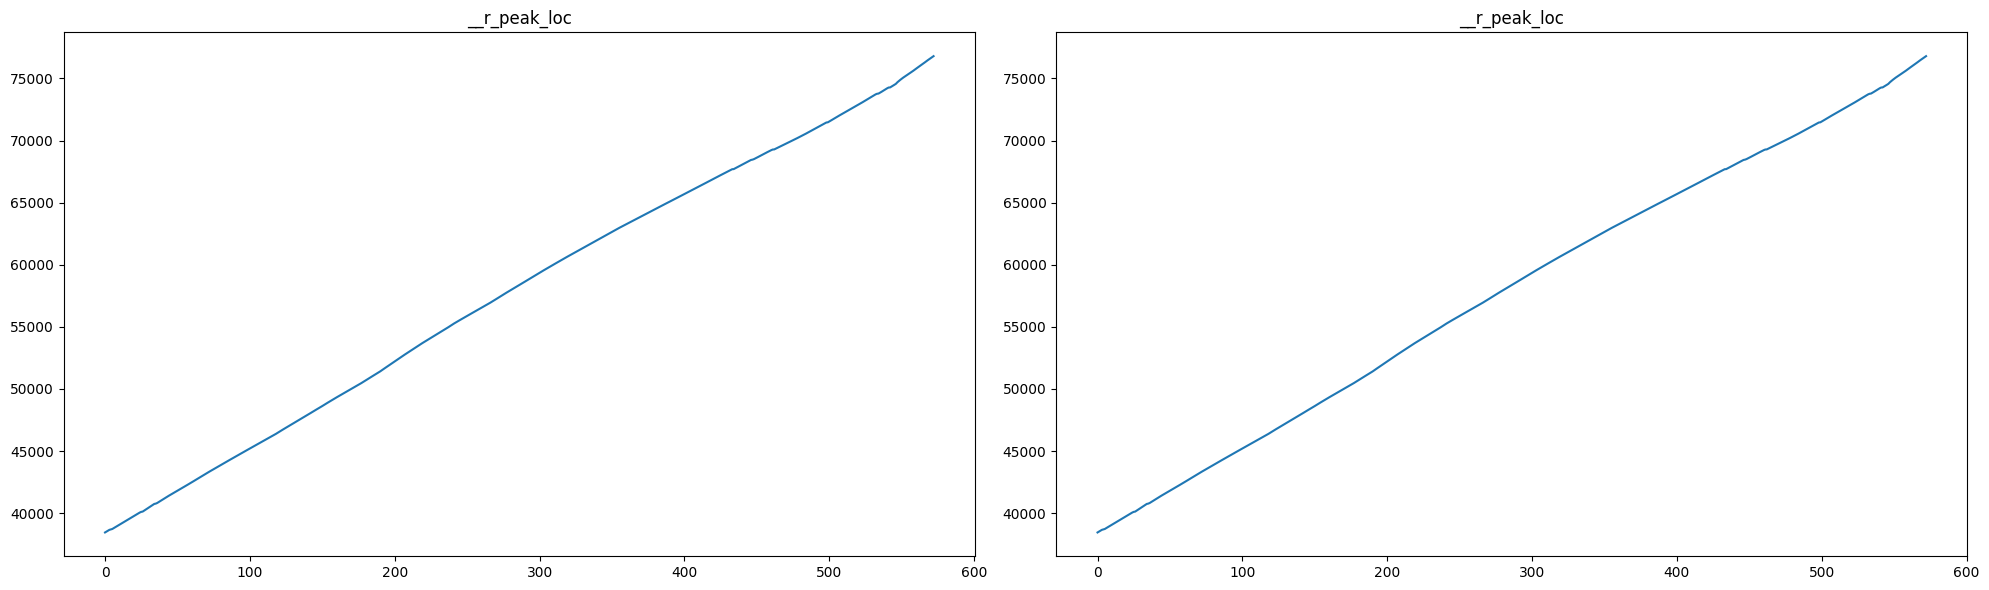

['N' '|' '~']


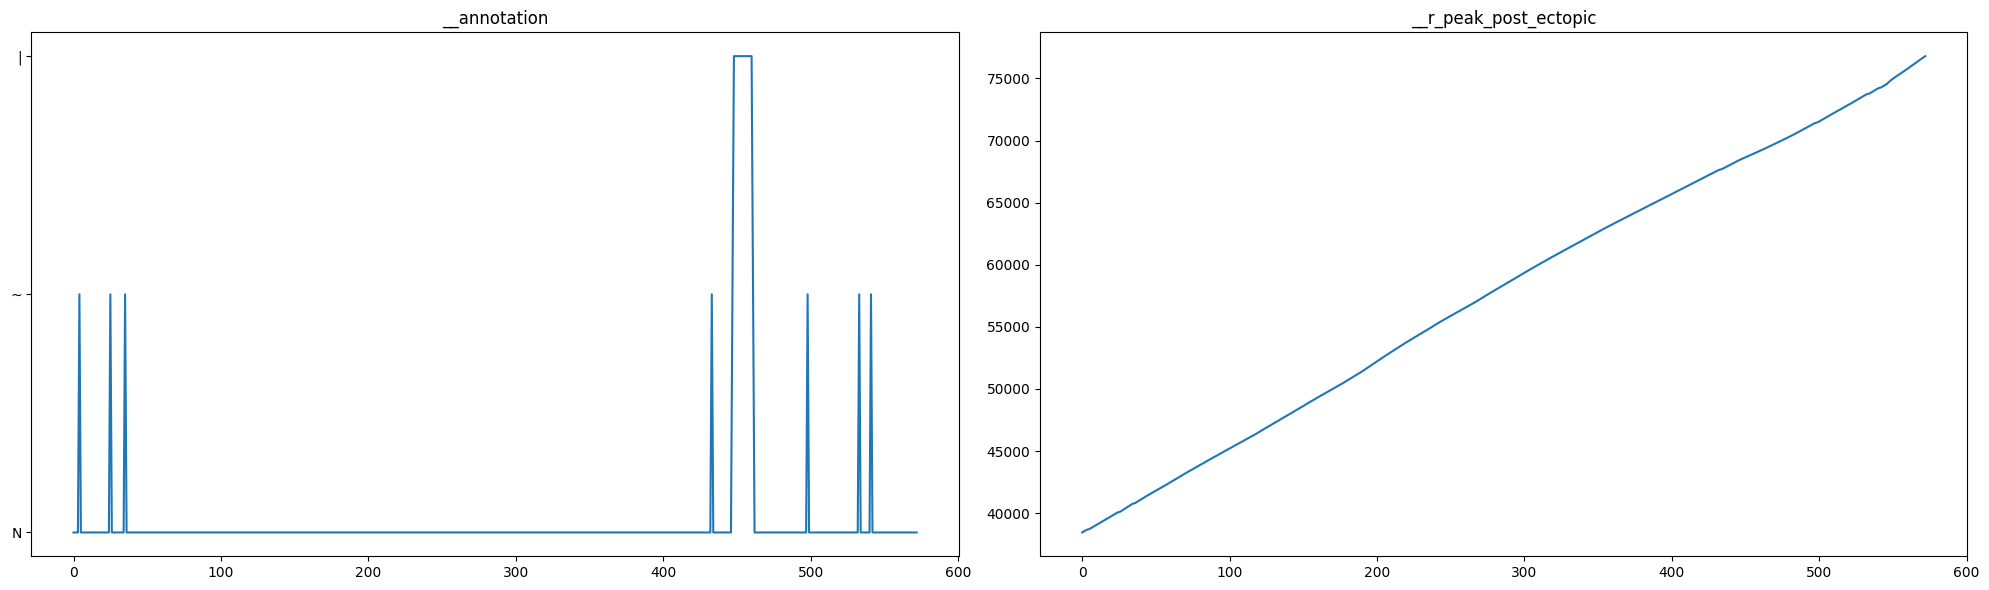

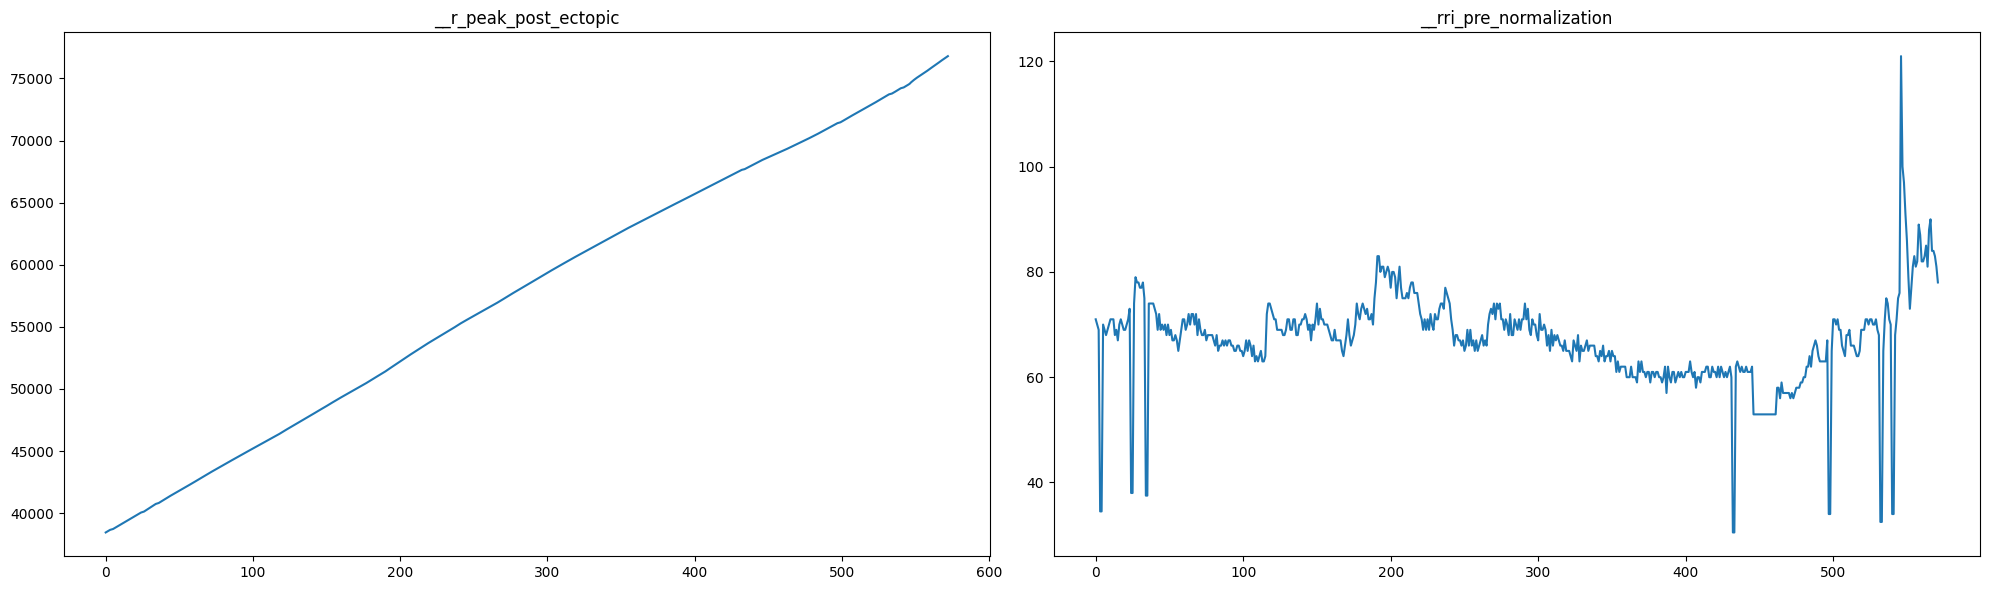

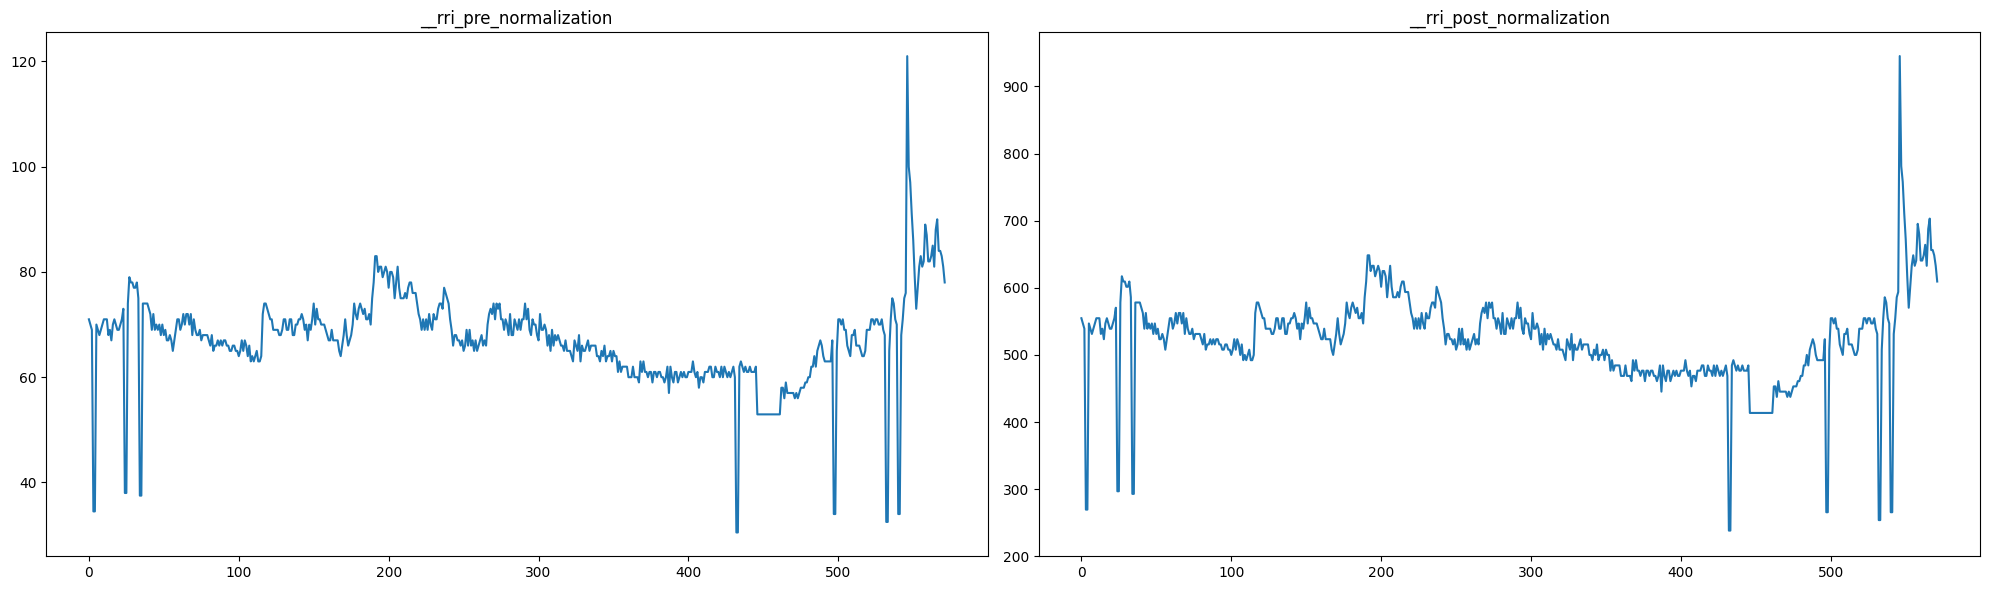

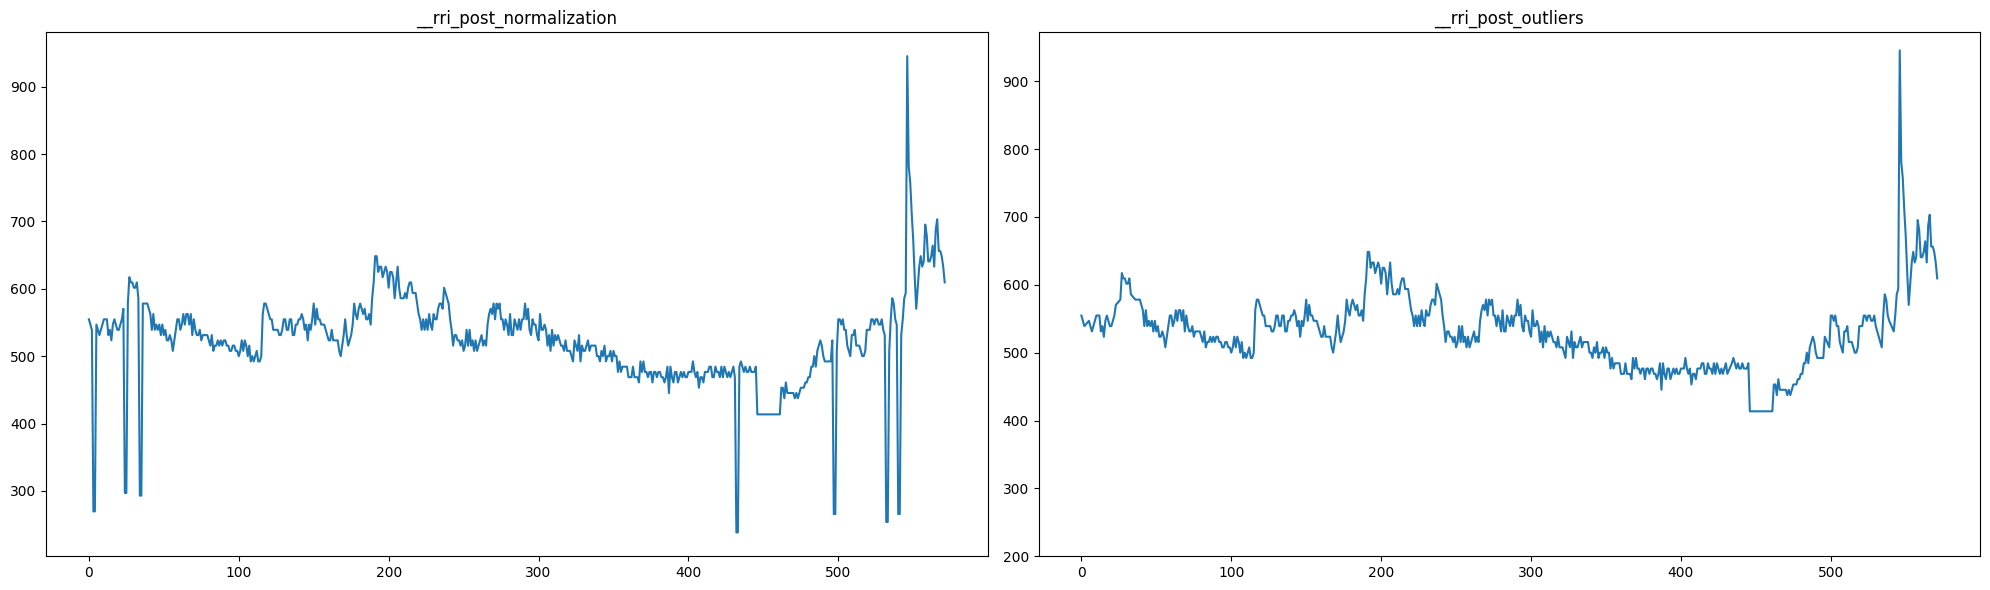

In [ ]:
to_plots = [
    "__r_peak_loc", "__annotation", "__r_peak_post_ectopic", "__rri_pre_normalization",
    "__rri_post_normalization", "__rri_post_outliers"
]
IDX = None
for idx_thing, thing in enumerate(to_plots):
    # if thing == "__r_peak_loc":
    #     for idx, (rl, anno) in enumerate(zip(nsrdb[sample_record][thing][:100], nsrdb[sample_record]["__annotation"][:100])):
    #         print(idx, rl, anno)
    if thing == "__annotation":
        print(np.unique(nsrdb[sample_record][thing]))
        continue
    # print(len(nsrdb[sample_record][thing][:]))
    fig = plt.figure(figsize=(20, 6))
    plt.title("{}".format(thing.split("__")[1]))
    if IDX:
        if thing in ["__r_peak_loc"]:
            print([int(val) if int(val) == val else val for val in nsrdb[sample_record][thing][:IDX]])
        else:
            print([int(val) if int(val) == val else val for val in nsrdb[sample_record][thing][:IDX]])
        # plt.plot(nsrdb[sample_record][to_plots[idx_thing]][:IDX])
        plt.subplot(1, 2, 1)
        plt.plot(nsrdb[sample_record][to_plots[max(0, idx_thing-1)]][:IDX])
        plt.title(to_plots[max(0, idx_thing-1)])
        plt.subplot(1, 2, 2)
        plt.plot(nsrdb[sample_record][to_plots[idx_thing]][:IDX])
        plt.title(to_plots[idx_thing])
        plt.tight_layout()
    else:
        # if thing in ["__r_peak_loc"]:
        #     print([int(val) if int(val) == val else val for val in nsrdb[sample_record][thing][:]])
        # else:
        #     print([int(val) if int(val) == val else val for val in nsrdb[sample_record][thing][:]])
        # plt.plot(nsrdb[sample_record][to_plots[idx_thing]][:IDX])
        plt.plot(nsrdb[sample_record][thing])
        plt.subplot(1, 2, 1)
        plt.plot(nsrdb[sample_record][to_plots[max(0, idx_thing-1)]])
        plt.title(to_plots[max(0, idx_thing-1)])
        plt.subplot(1, 2, 2)
        plt.plot(nsrdb[sample_record][to_plots[idx_thing]])
        plt.title(to_plots[idx_thing])
        plt.tight_layout()
    if thing in ["__rri_post_normalization", "__rri_post_outliers"]:
        plt.yticks([100*i for i in range(2, 10)])
    plt.show()

## SampEn

In [ ]:
import nolds

[[ 1 11 21]
 [ 2 12 22]
 [ 3 13 23]
 [ 4 14 24]
 [ 5 15 25]
 [ 6 16 26]
 [ 7 17 27]
 [ 8 18 28]
 [ 9 19 29]
 [10 20 30]]
(10, 3)
False
True


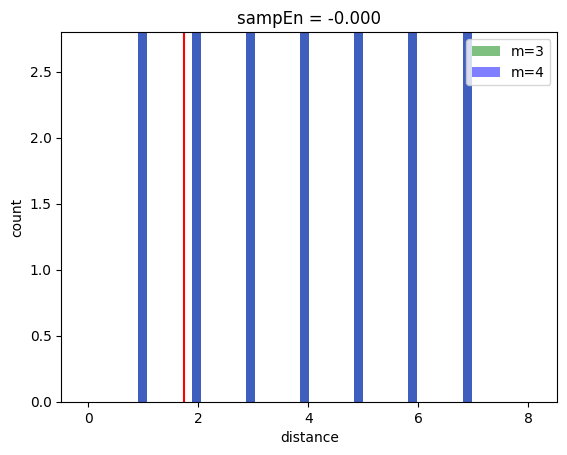

-0.0


In [ ]:
nni = [i+1 for i in range(30)]
# nolds.sampen(nni, emb_dim=2)
emb_dim = 2+1
arr = nolds.measures.delay_embedding(nni, emb_dim=emb_dim, lag=10)
print(arr)
print(arr.shape)
# first dim is N - m + 1
print( arr.shape[0] == len(nni) - emb_dim + 1)
# second dim is m
print( arr.shape[1] == emb_dim + 1 - 1)

print(nolds.sampen(arr, emb_dim=2, debug_plot=True))

In [ ]:
tVecs = nolds.measures.delay_embedding(np.asarray(nni), emb_dim=emb_dim+1, lag=1)

In [ ]:
tVecs

array([[ 1,  2,  3,  4],
       [ 2,  3,  4,  5],
       [ 3,  4,  5,  6],
       [ 4,  5,  6,  7],
       [ 5,  6,  7,  8],
       [ 6,  7,  8,  9],
       [ 7,  8,  9, 10],
       [ 8,  9, 10, 11],
       [ 9, 10, 11, 12],
       [10, 11, 12, 13],
       [11, 12, 13, 14],
       [12, 13, 14, 15],
       [13, 14, 15, 16],
       [14, 15, 16, 17],
       [15, 16, 17, 18],
       [16, 17, 18, 19],
       [17, 18, 19, 20],
       [18, 19, 20, 21],
       [19, 20, 21, 22],
       [20, 21, 22, 23],
       [21, 22, 23, 24],
       [22, 23, 24, 25],
       [23, 24, 25, 26],
       [24, 25, 26, 27],
       [25, 26, 27, 28],
       [26, 27, 28, 29],
       [27, 28, 29, 30]])